# Required Libraries & Dependencies

In [1]:
#Necessary Libaries
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
import scipy.signal
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Cloning Dataset from GitHub

In [2]:
#Getting Data From GitHub
!git clone https://github.com/SiddharthSubramanian1729/EmotionRAVDESS

Cloning into 'EmotionRAVDESS'...
remote: Enumerating objects: 1466, done.
remote: Total 1466 (delta 0), reused 0 (delta 0), pack-reused 1466 (from 1)
Receiving objects: 100% (1466/1466), 213.82 MiB | 26.30 MiB/s, done.
Resolving deltas: 100% (239/239), done.
Updating files: 100% (2880/2880), done.


# Setting up of the Emotion Map - Done as per Dataset description

In [3]:
emotion_map = {
    '01': 'neutral', '02': 'happy', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

In [4]:
base_dir = "/content/EmotionRAVDESS"
data = []
for actor_folder in sorted(os.listdir(base_dir)):
    actor_path = os.path.join(base_dir, actor_folder)
    if not os.path.isdir(actor_path):
      continue
    for file in os.listdir(actor_path):
        if not file.endswith('.wav'): continue
        parts = file.split('-')
        emotion = emotion_map[parts[2]]
        intensity = 'strong' if parts[3] == '02' else 'normal'
        actor_id = int(parts[-1].split('.')[0])
        gender = 'male' if actor_id % 2 == 1 else 'female'
        data.append({
            'file_path': os.path.join(actor_path, file),
            'emotion': emotion,
            'intensity': intensity,
            'actor': actor_id,
            'gender': gender
        })

df = pd.DataFrame(data)

# Audio Preprocessing

## Includes:

* `load_audio` - This ensures all audio inputs are clean, mono, and amplitude-normalized for feature extraction
* `highpass_filter` - This helps isolate speech-relevant frequencies and improves feature clarity with a high-pass filter cutoff at 100 Hz
* `pad_or_truncate` - This guarantees uniform input shape for CNNs, RNNs, or spectrogram generation. - Pads with zeros if the audio is shorter than target_len (e.g., 3 seconds at 16kHz). Truncates if longer, ensuring fixed-size input for models




In [5]:
def load_audio(path, sr=16000):
    """Load and preprocess audio"""
    y, _ = librosa.load(path, sr=sr, mono=True)
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    y = y_trimmed / (np.max(np.abs(y_trimmed)) + 1e-8)
    return y

def highpass_filter(y, sr, cutoff=100):
    """Remove low-frequency noise"""
    sos = scipy.signal.butter(10, cutoff, 'hp', fs=sr, output='sos')
    return scipy.signal.sosfilt(sos, y)

def pad_or_truncate(y, target_len=48000):
    """Fix audio length"""
    if len(y) < target_len:
        return np.pad(y, (0, target_len - len(y)))
    else:
        return y[:target_len]

# Audio Feature Extraction Pipeline

* This pipeline loads and cleans raw audio files using silence trimming, high-pass filtering, and fixed-length padding.  
* It extracts temporal features including `MFCCs`, `Mel spectrograms`, `ZCR`, `RMSE`, and `spectral descriptors`.  
* All feature arrays are padded to a uniform time dimension for batch compatibility.  
* Emotion labels are encoded and the dataset is split using stratified sampling.  
* Simple data augmentation (noise injection and scaling) is applied to boost training diversity.  
* Final outputs are ready for input into deep learning models like CNN-GRU with attention.

In [6]:
def extract_features_temporal(y, sr):
    """Extract features preserving temporal structure"""
    # MFCC and deltas
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

    # Spectral features
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)

    zcr = librosa.feature.zero_crossing_rate(y)
    rmse = librosa.feature.rms(y=y)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

    # Stack all features
    features = np.vstack([
        mfcc,
        mfcc_delta,
        mfcc_delta2,
        mel_db,
        zcr,
        rmse,
        spectral_centroid,
        spectral_rolloff
    ])

    return features

# PROCESS ALL AUDIO FILES


print("\n" + "="*50)
print("EXTRACTING FEATURES FROM AUDIO FILES")
print("="*50)

X_temporal = []
y_labels = []

for i, row in df.iterrows():
    try:
        y_audio = load_audio(row['file_path'], sr=16000)
        y_audio = highpass_filter(y_audio, sr=16000)
        y_audio = pad_or_truncate(y_audio, target_len=48000)

        features = extract_features_temporal(y_audio, sr=16000)
        X_temporal.append(features)
        y_labels.append(row['emotion'])

        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{len(df)} files")
    except Exception as e:
        print(f"Error processing {row['file_path']}: {e}")

print(f"Successfully processed {len(X_temporal)} files")


# NORMALIZE FEATURE DIMENSIONS

# Pad/truncate time dimension to fixed length
max_time = max([x.shape[1] for x in X_temporal])
print(f"\nMax time frames: {max_time}")
print(f"Feature dimensions: {X_temporal[0].shape[0]}")

X_padded = []
for features in X_temporal:
    if features.shape[1] < max_time:
        pad_width = max_time - features.shape[1]
        features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
    else:
        features = features[:, :max_time]
    X_padded.append(features)

X_padded = np.array(X_padded)
print(f"Final feature shape: {X_padded.shape}")


# ENCODE LABELS AND SPLIT DATA


le = LabelEncoder()
y_encoded = le.fit_transform(y_labels)
print(f"\nClasses: {le.classes_}")

X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")


# DATA AUGMENTATION (TRAINING ONLY)


print("\n" + "="*50)
print("APPLYING DATA AUGMENTATION")
print("="*50)

X_train_aug = []
y_train_aug = []

for x, y_label in zip(X_train, y_train):
    # Original
    X_train_aug.append(x)
    y_train_aug.append(y_label)

    # Augmented: add small noise
    noise = np.random.randn(*x.shape) * 0.01
    X_train_aug.append(x + noise)
    y_train_aug.append(y_label)

    # Augmented: scale features slightly
    scale = np.random.uniform(0.95, 1.05)
    X_train_aug.append(x * scale)
    y_train_aug.append(y_label)

X_train = np.array(X_train_aug)
y_train = np.array(y_train_aug)

print(f"Augmented training samples: {len(X_train)}")


EXTRACTING FEATURES FROM AUDIO FILES
Processed 100/1440 files
Processed 200/1440 files
Processed 300/1440 files
Processed 400/1440 files
Processed 500/1440 files
Processed 600/1440 files
Processed 700/1440 files
Processed 800/1440 files
Processed 900/1440 files
Processed 1000/1440 files
Processed 1100/1440 files
Processed 1200/1440 files
Processed 1300/1440 files
Processed 1400/1440 files
Successfully processed 1440 files

Max time frames: 94
Feature dimensions: 188
Final feature shape: (1440, 188, 94)

Classes: ['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Train samples: 1152, Test samples: 288

APPLYING DATA AUGMENTATION
Augmented training samples: 3456


# PyTorch Dataset and DataLoader Setup

* This section converts preprocessed NumPy arrays into PyTorch tensors for training and evaluation.  
* It wraps the data into `TensorDataset` objects and creates `DataLoaders` for efficient batching.  
* Training data is shuffled to improve generalization, while test data is loaded sequentially. Each input tensor is unsqueezed to add a channel dimension for CNN compatibility.  
* The final print statement confirms the shape of a sample training batch.

In [7]:

# CREATE PYTORCH DATASETS


X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Batch shape: {next(iter(train_loader))[0].shape}")


Batch shape: torch.Size([32, 1, 188, 94])


# Model Architecture Definition

### CNN-GRU-Attention Model Architecture

- Uses a 3-layer CNN block to extract spatial features from time-frequency inputs (e.g., Mel spectrograms).
- Applies batch normalization, ReLU activation, max pooling, and dropout for regularization.
- Reshapes CNN output to match GRU input format by averaging across frequency dimensions.
- Employs a 2-layer bidirectional GRU to capture temporal dependencies in emotional speech.
- Implements an attention mechanism to weight time steps based on emotional salience.
- Final classification is done via a 3-layer fully connected network with dropout and ReLU.

In [8]:

# DEFINE MODEL ARCHITECTURE

class CNN_GRU_Attention(nn.Module):
    def __init__(self, num_classes=8, input_features=198):
        super(CNN_GRU_Attention, self).__init__()

        # CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.2),

            nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.2),

            nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.2)
        )

        # Calculate the flattened dimension after CNN
        # We'll compute this dynamically in forward pass
        self.gru_input_size = None

        # GRU for temporal modeling
        self.gru = nn.GRU(
            input_size=256,  # Will be set correctly after first forward pass
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )

        # Attention
        self.attn = nn.Linear(256, 1)

        # Classifier
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (batch, 1, features, time)
        batch_size = x.size(0)

        # CNN processing
        x = self.cnn(x)  # (batch, 256, features', time')

        # Reshape for GRU: (batch, time, features)
        # Flatten the frequency dimension but keep time
        x = x.permute(0, 3, 1, 2)  # (batch, time', channels, features')

        # Average pool across frequency dimension to reduce to single feature per channel
        x = x.mean(dim=3)  # (batch, time', channels)

        # Now x is (batch, time, 256) which is what GRU expects
        gru_out, _ = self.gru(x)  # (batch, time, 256)

        # Attention mechanism
        attn_weights = F.softmax(self.attn(gru_out), dim=1)  # (batch, time, 1)
        context = torch.sum(attn_weights * gru_out, dim=1)  # (batch, 256)

        # Classification
        out = self.fc(context)
        return out



In [15]:
# ============================================
# 9. FIX CLASS IMBALANCE (Before data loading)
# ============================================

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

print("\n" + "="*50)
print("ANALYZING CLASS DISTRIBUTION")
print("="*50)

# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {le.inverse_transform([cls])[0]}: {count} samples ({count/len(y_train)*100:.1f}%)")

print("\nClass weights:")
for cls, weight in enumerate(class_weights):
    print(f"  Class {le.inverse_transform([cls])[0]}: {weight:.4f}")

# ============================================
# 10. TRAINING SETUP (WITH CLASS WEIGHTS)
# ============================================

print("\n" + "="*50)
print("TRAINING MODEL")
print("="*50)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CNN_GRU_Attention(num_classes=len(le.classes_)).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# CRITICAL: Use weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# ============================================
# 11. TRAINING LOOP WITH CLASS BALANCE FOCUS
# ============================================

num_epochs = 100
best_val_acc = 0
patience_counter = 0
early_stop_patience = 15

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        train_correct += (preds.argmax(1) == y_batch).sum().item()
        train_total += y_batch.size(0)

    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            val_loss += criterion(preds, y_batch).item()
            val_correct += (preds.argmax(1) == y_batch).sum().item()
            val_total += y_batch.size(0)

    train_acc = train_correct / train_total
    val_acc = val_correct / val_total
    avg_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)

    scheduler.step(avg_val_loss)

    gap = train_acc - val_acc
    print(f"Epoch {epoch+1:3d}/{num_epochs} | "
          f"Loss: {avg_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | "
          f"Val Acc: {val_acc:.4f} | "
          f"Gap: {gap:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"  ✓ New best model saved! (Val Acc: {val_acc:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f"\n✓ Early stopping at epoch {epoch+1}")
            break

print(f"\n✓ Best validation accuracy: {best_val_acc:.4f}")
model.load_state_dict(torch.load('best_model.pt'))


ANALYZING CLASS DISTRIBUTION
Class distribution:
  Class angry: 459 samples (13.3%)
  Class disgust: 462 samples (13.4%)
  Class fearful: 462 samples (13.4%)
  Class happy: 921 samples (26.6%)
  Class neutral: 231 samples (6.7%)
  Class sad: 459 samples (13.3%)
  Class surprised: 462 samples (13.4%)

Class weights:
  Class angry: 1.0756
  Class disgust: 1.0686
  Class fearful: 1.0686
  Class happy: 0.5361
  Class neutral: 2.1373
  Class sad: 1.0756
  Class surprised: 1.0686

TRAINING MODEL
Using device: cuda
Model parameters: 1,005,320
Epoch   1/100 | Loss: 1.9338 | Train Acc: 0.1484 | Val Acc: 0.1424 | Gap: 0.0061
  ✓ New best model saved! (Val Acc: 0.1424)
Epoch   2/100 | Loss: 1.8792 | Train Acc: 0.1586 | Val Acc: 0.1632 | Gap: -0.0046
  ✓ New best model saved! (Val Acc: 0.1632)
Epoch   3/100 | Loss: 1.8366 | Train Acc: 0.1803 | Val Acc: 0.1875 | Gap: -0.0072
  ✓ New best model saved! (Val Acc: 0.1875)
Epoch   4/100 | Loss: 1.8144 | Train Acc: 0.1753 | Val Acc: 0.1424 | Gap: 0.0330

<All keys matched successfully>

# Final Evaluation on the test set


FINAL EVALUATION ON TEST SET

Classification Report:
              precision    recall  f1-score   support

       angry       0.62      0.72      0.67        39
     disgust       0.77      0.63      0.70        38
     fearful       0.45      0.66      0.53        38
       happy       0.58      0.40      0.48        77
     neutral       0.31      0.47      0.38        19
         sad       0.39      0.33      0.36        39
   surprised       0.68      0.74      0.71        38

    accuracy                           0.55       288
   macro avg       0.54      0.56      0.55       288
weighted avg       0.57      0.55      0.55       288


FINAL TEST ACCURACY: 54.86%


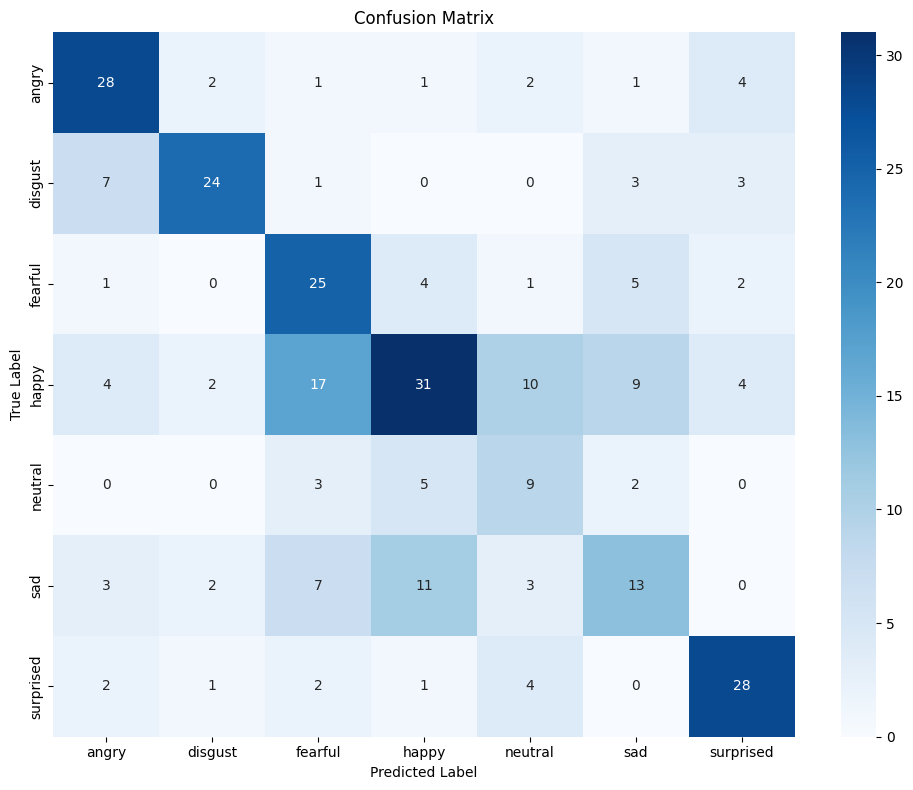

In [16]:
# FINAL EVALUATION


print("\n" + "="*50)
print("FINAL EVALUATION ON TEST SET")
print("="*50)

model.load_state_dict(torch.load('best_model.pt'))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        y_pred.extend(preds.argmax(1).cpu().numpy())
        y_true.extend(y_batch.numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Calculate and display accuracy
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

final_accuracy = accuracy_score(y_true, y_pred)
print(f"\n{'='*50}")
print(f"FINAL TEST ACCURACY: {final_accuracy:.2%}")
print(f"{'='*50}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Predictions

In [ ]:
# ======= PREDICTION HELPERS =======
import torch
import numpy as np
import pandas as pd
import os
import torch.nn.functional as F

def preprocess_for_model(file_path, sr=16000, target_len=48000, do_highpass=True):
    """
    Load audio and extract the temporal features expected by the model.
    Returns a numpy array shaped (channels=1, features, time) ready for tensor conversion.
    """
    y = load_audio(file_path, sr=sr)
    if do_highpass:
        y = highpass_filter(y, sr=sr)
    y = pad_or_truncate(y, target_len=target_len)
    feats = extract_features_temporal(y, sr=sr)  # shape: (n_features, n_frames)
    return feats

def features_to_tensor(feats):
    """
    Convert feature numpy array (n_features, n_frames) to the PyTorch input tensor
    shape expected by the model: (1, 1, n_features, n_frames)
    """
    arr = np.asarray(feats, dtype=np.float32)
    # ensure 2D (features, time)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    # Add channel & batch dims
    tensor = torch.tensor(arr).unsqueeze(0).unsqueeze(0)  # (1,1,features,time)
    return tensor

def predict_file(path, model, device, le, sr=16000, target_len=48000, top_k=3, return_probs=False):
    """
    Predict the emotion for a single WAV file.
    Returns:
      pred_label (str), confidence (float), topk (list of (label, prob)) if return_probs True
    """
    model.eval()
    feats = preprocess_for_model(path, sr=sr, target_len=target_len)
    x_tensor = features_to_tensor(feats).to(device)

    with torch.no_grad():
        logits = model(x_tensor)                       # shape (1, num_classes)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]  # numpy array (num_classes,)

    # Top-1
    top_idx = probs.argmax()
    pred_label = le.inverse_transform([top_idx])[0]
    confidence = float(probs[top_idx])

    # top-k list (label, prob)
    topk_idx = probs.argsort()[::-1][:top_k]
    topk = [(le.inverse_transform([int(i)])[0], float(probs[int(i)])) for i in topk_idx]

    if return_probs:
        return pred_label, confidence, topk, probs
    else:
        return pred_label, confidence, topk

def predict_folder(folder, model, device, le, sr=16000, target_len=48000, top_k=3):
    """
    Run prediction for all .wav files in a folder. Returns a pandas DataFrame:
      file_path | pred_label | confidence | top_k
    """
    rows = []
    for root, _, files in os.walk(folder):
        for fname in files:
            if not fname.lower().endswith('.wav'):
                continue
            fp = os.path.join(root, fname)
            try:
                pred_label, conf, topk = predict_file(fp, model, device, le, sr, target_len, top_k)
                rows.append({
                    "file_path": fp,
                    "pred_label": pred_label,
                    "confidence": conf,
                    "top_k": topk
                })
            except Exception as e:
                rows.append({"file_path": fp, "pred_label": None, "confidence": 0.0, "top_k": [], "error": str(e)})
    return pd.DataFrame(rows)

# ======= Example usage =======
# 1) Load model weights (if not already loaded)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_GRU_Attention(num_classes=len(le.classes_)).to(device)
model.load_state_dict(torch.load('best_model.pt', map_location=device))
model.eval()

# 2) Predict on a single file
test_file = "/content/EmotionRAVDESS/Actor_02/03-01-01-01-01-01-02.wav"
pred_label, confidence, topk = predict_file(test_file, model, device, le, return_probs=False)
print(f"Predicted: {pred_label} (confidence: {confidence:.3f})")
print("Top-K:", topk)

# 3) Predict on a folder (batch)
results_df = predict_folder("/content/EmotionRAVDESS", model, device, le)
print(results_df.head())


Predicted: neutral (confidence: 0.951)
Top-K: [(np.str_('neutral'), 0.950557291507721), (np.str_('surprised'), 0.028493711724877357), (np.str_('happy'), 0.01597581058740616)]
